# Link to the video is in the private comment

# Import all the required Python libraries

In [27]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Configure various possible scenarios

In [105]:
def get_default_city_configurations():
  '''
  To return the configurations of a default town 
  '''
  config = {'map_size': 100,
            'civilian_count': 1000,
            'average_degree': 2,
            'cascading_limit': 1,
            'robber_count': 1,
            'robber_radar': 10,
            'murder_threshold': 0.6,
            'robber_sleight': 'normal',
            'robber_type': 'solo',
            'cop_count': 1,
            'cop_radar': 5,
            'cop_alertness_range': 2}
  return config


def get_village_configurations():
  '''
  To return the configurations of a village 
  '''
  config = {'map_size': 50,
            'civilian_count': 500,
            'average_degree': 3,
            'cascading_limit': 1,
            'robber_count': 1,
            'robber_radar': 10,
            'murder_threshold': 0.6,
            'robber_sleight': 'normal',
            'robber_type': 'solo',
            'cop_count': 1,
            'cop_radar': 5,
            'cop_alertness_range': 2}
  return config


def get_metropolitan_configurations():
  '''
  To return the configurations of a metropolitan city 
  '''
  config = {'map_size': 120,
            'civilian_count': 1500,
            'average_degree': 2,
            'cascading_limit': 1,
            'robber_count': 1,
            'robber_radar': 10,
            'murder_threshold': 0.6,
            'robber_sleight': 'normal',
            'robber_type': 'solo',
            'cop_count': 1,
            'cop_radar': 5,
            'cop_alertness_range': 2}
  return config


def get_community_strength_configurations(config,average_degree):
  '''
  To return the configurations of a weak community setup 
  '''
  #config = get_default_city_configurations()
  config['average_degree'] = average_degree
  return config


def get_cascading_alertness_configurations(config,cascading_limit):
  '''
  To return the configurations for varrying cascading alertness originating from the crime scene
  '''
  #config = get_default_city_configurations()
  config['cascading_limit'] = cascading_limit
  return config


def get_crime_intensity_configurations(config,murder_threshold):
  '''
  To return the configurations of varrying crime intensity in the city
  '''
  #config = get_default_city_configurations()
  config['murder_threshold'] = murder_threshold
  return config



def get_multi_robber_configurations(robber_count,type):
  '''
  To return the configurations of a multiple robber setup 
  '''
  if(type==1):
    config = get_default_city_configurations()
    config['robber_count'] = robber_count
  elif(type==2):
    config = get_metropolitan_configurations()
    config['robber_count'] = robber_count
  else:
    config = get_village_configurations()
    config['robber_count'] = robber_count
  return config


def get_multi_cop_configurations(cop_count,ss,rr):
  '''
  To return the configurations of a multiple cop setup
  '''
  
  config = get_default_city_configurations()
  config['robber_count'] = rr
  config['cop_count'] = cop_count
  return config


def get_multi_cop_robber_configurations(cop_count,robber_count,type):
  if(type==1):
    config = get_default_city_configurations()
    config['cop_count'] = cop_count
    config['robber_count'] = robber_count
  elif(type==2):
    config = get_metropolitan_configurations()
    config['cop_count'] = cop_count
    config['robber_count'] = robber_count
  else:
    config = get_village_configurations()
    config['cop_count'] = cop_count
    config['robber_count'] = robber_count

  #config = get_default_city_configurations()
  #config['cop_count'] = cop_count
  #config['robber_count'] = robber_count
  return config

def get_solo_or_gang_robber_configurations(robber_count, robber_type):
  '''
  To return the configurations of multiple robbers acting solo or in a gang 
  '''
  config = get_default_city_configurations()
  config['robber_count'] = robber_count
  config['robber_type'] = robber_type
  return config


def get_greedy_robber_configurations(robber_sleight):
  '''
  To return the configurations for varrying robber greediness
  '''
  config = get_default_city_configurations()
  config['robber_sleight'] = robber_sleight
  return config


# Define the utility functions

In [29]:
def get_random_value(start=0.0, end=1.0):
  '''
  To randomly pick a value between 0 and 1 
  '''
  return np.random.random()


def get_uniformly_random(start, end):
  '''
  To pick a value uniformly at random from the given range
  '''
  return np.random.randint(start, end)


def get_random_coordinates(start, end):
  '''
  To randomly pick and return x and y coordinates from the given range
  '''
  return int(get_uniformly_random(start, end)), int(get_uniformly_random(start, end))


def manhattan(n1, n2):
  '''
  To calculate and return the Manhattan distance between the given nodes
  '''
  return abs(n2[0] - n1[0]) + abs(n2[1] - n1[1])


def euclidean(n1, n2):
  '''
  To calculate and return the Euclidean distance between the given nodes
  '''
  #print('n1', n1)
  #print('n2', n2)
  return round(((n2[0] - n1[0]) ** 2 + (n2[1] - n1[1]) ** 2) ** 0.5)


def kill_civilian(city, civilian_id):
  '''
  To remove a civilian from the city
  '''
  city.remove_node(civilian_id)
  return city


def add_civilian(city, config, civilian_coordinates, civilian_id):
  '''
  To add a civilian in the city
  '''
  limit = config['map_size'] - 1

  x_coordinate, y_coordinate = get_random_coordinates(0, limit)

  # Ensure the coordinates are distinct
  while (x_coordinate, y_coordinate) in civilian_coordinates.keys():
    x_coordinate, y_coordinate = get_random_coordinates(0, limit)

  civilian_coordinates[(x_coordinate, y_coordinate)] = civilian_id
  city.add_node(civilian_id, pos=(x_coordinate, y_coordinate), cash=get_uniformly_random(0, 100), alertness=round(get_random_value(),1))

  return city, civilian_coordinates


def add_civilians(city, config):
  '''
  To populate the city with civilians
  '''
  # To map the coordinates with the civilian id
  civilian_coordinates = {}

  for civilian_id in range(config['civilian_count']):
    city, civilian_coordinates = add_civilian(city, config, civilian_coordinates, civilian_id)

  return city, civilian_coordinates


def add_relationships(city, config, civilian_coordinates, verbose=False):
  '''
  To populate the city with civilians
  '''
  civilian_ids = list(civilian_coordinates.values())
  edge_count = 0

  while edge_count < (config['civilian_count'] * config['average_degree']) // 2:
    civilian_1 = np.random.choice(civilian_ids)
    civilian_2 = np.random.choice(civilian_ids)

    civilian_1_coordinates = list(civilian_coordinates.keys())[list(civilian_coordinates.values()).index(civilian_1)]
    civilian_2_coordinates = list(civilian_coordinates.keys())[list(civilian_coordinates.values()).index(civilian_2)]

    if civilian_1 == civilian_2:
      continue

    random_value = get_random_value()
    relationship_threshold = 0.05 * manhattan(civilian_1_coordinates, civilian_2_coordinates)

    if random_value > relationship_threshold:
      city.add_edge(civilian_1, civilian_2)
      edge_count += 1 

      if verbose:
        print('Relationship #{}'.format(edge_count))

  return city


def create_city(config, verbose=True):
  '''
  To randomly populate the city and create a friendship network 
  '''
  # To create a city with civilians and relationships between them
  city = nx.Graph()
  if verbose:
    print('City Created!')

  city, civilian_coordinates = add_civilians(city, config)
  if verbose:
    print('Civilians Added!')

  city = add_relationships(city, config, civilian_coordinates)
  if verbose:
    print('Relationships Established.')

  return city


def add_robbers(city, config):
  '''
  To randomly place robber/s in the city
  '''
  robber_info = {'pos': [], 'cash': [], 'active': 0}
  for i in range(config['robber_count']):
    x_coordinate, y_coordinate = get_random_coordinates(0, config['map_size'] - 1)
    robber_info['pos'].append((x_coordinate, y_coordinate))
    robber_info['cash'].append(get_uniformly_random(0, 100))

  return city, robber_info


def add_cops(city, config):
  '''
  To randomly place robber/s in the city
  '''
  cop_info = {'pos': []}
  for i in range(config['cop_count']):
    x_coordinate, y_coordinate = get_random_coordinates(0, config['map_size'] - 1)
    # city.add_node(city.number_of_nodes() + 1, pos=(x_coordinate, y_coordinate), cash=-1, alertness=-1)
    cop_info['pos'].append((x_coordinate, y_coordinate))

  return city, cop_info



# Lifecycle of a Robber

In [43]:
def is_potential_target(config, robber_info, civilian_coordinates):
  '''
  To check if given civilian is a potential target for the robber
  '''
  is_target = False

  for i in range(len(robber_info['pos'])):

    robber_coordinates = robber_info['pos'][i]
    limit = min(config['robber_radar'], robber_info['cash'][i])

    if abs(robber_coordinates[0] - civilian_coordinates[0]) > limit:
      continue
    
    elif manhattan(robber_coordinates, civilian_coordinates) > limit:
        continue
  
    is_target = True

    if is_target: 
      break

  return is_target


def scan_neighborhood(city, config, robber_info):
  '''
  To scan the civilians present near the robber
  '''
  potential_targets = {}

  for i in range(config['robber_count']):

    for civilian in city.nodes(data=True):

      if is_potential_target(config, robber_info, civilian[1]['pos']):

        potential_targets[civilian[0]] = civilian[1]['cash']

  return potential_targets


def select_target_civilian(potential_targets):
  '''
  To pick a single target from all the potential targets
  '''
  print(potential_targets)
  return random.choices(list(potential_targets.keys()), list(potential_targets.values()))[0]


def move_to_target_civilian(city, robber_info, target_civilian):
  '''
  To move the robber to the target civilian's coordinates
  '''
  print('moving from:', robber_info)

  civilian_coordinates = city.nodes[target_civilian]['pos']

  next_robber_cash_spent = 999999

  for i in range(len(robber_info['pos'])):
    robber_cash_spent = manhattan(robber_info['pos'][i], civilian_coordinates)

    if robber_cash_spent < next_robber_cash_spent:
       robber_info['active'] = i
       next_robber_cash_spent = robber_cash_spent

  robber_info['pos'][robber_info['active']] = civilian_coordinates
  robber_info['cash'][robber_info['active']] -= next_robber_cash_spent

  print('moved:', robber_info)

  return robber_info


def spread_alertness(city, target_civilian, crime):
  '''
  To spread alertness
  '''
  print('target_civilian:', target_civilian)
  if crime == 'robbery':
    city.nodes[target_civilian]['alertness'] = 1.0
    for n in city.neighbors(target_civilian):
      city.nodes[n]['alertness'] = min(city.nodes[n]['alertness'] + 0.5, 1.0)

  else:
    for n in city.neighbors(target_civilian):
      city.nodes[n]['alertness'] = 1.0

  return city
  

def perform_crime(city, config, robber_info, target_civilian):
  '''
  To commit robbery or murder
  '''
  crimes = []
  crime_scenes = []

  crime = None
  civilian_cash = city.nodes[target_civilian]['cash']
  crime_likelihood = get_random_value()

  # Check if liklihood of crime is more than civilian's alertness
  if crime_likelihood > city.nodes[target_civilian]['alertness']:
    random_value = get_random_value()

    if random_value < config['murder_threshold']:
      crime = 'robbery'
      crimes.append(crime)
      crime_scenes.append(city.nodes[target_civilian]['pos'])

      random_fraction = get_uniformly_random(30, 70)
      cash_stolen = int(civilian_cash * random_fraction / 100)
      city.nodes[target_civilian]['cash'] -= cash_stolen
      robber_info['cash'][robber_info['active']] += cash_stolen
      city = spread_alertness(city, target_civilian, crime)

    else:
      crime = 'murder'
      crimes.append(crime)
      crime_scenes.append(city.nodes[target_civilian]['pos'])
      robber_info['cash'][robber_info['active']] += civilian_cash
      city = spread_alertness(city, target_civilian, crime)
      city.remove_node(target_civilian)

  return city, robber_info, crimes, crime_scenes


def flee_crime_scence(city, config, robber_info, target_civilian):
  '''
  To flee the crime scene
  '''
  prev_pos = robber_info['pos'][0]
  robber_info['pos'][0] = get_random_coordinates(0, config['map_size'] - 1)
  cash_spent = manhattan(robber_info['pos'][0], prev_pos)

  while cash_spent > robber_info['cash'][0]:
    robber_info['pos'][0] = get_random_coordinates(0, config['map_size'] - 1)
    cash_spent = manhattan(robber_info['pos'][0], prev_pos)
  
  robber_info['cash'][0] -= cash_spent

  return robber_info



# Lifecycle of a Cop

In [31]:
# def find_closest_cop_to_crime_scene(cop_info, crime_scene):
#   '''
#   To find the closest cop to the given crime scene
#   '''




def move_to_crime_scene(cop_info, crime_scene):
  '''
  To move the robber to the target civilian's coordinates
  '''
  cop_info['pos'][0] = crime_scene
  return cop_info


def get_equation_of_line(p1, p2):
  '''
  To return the coefficients of a straight line passing through the given points
  '''
  #print('p1:', p1)
  #print('p2:', p2)

  x = [p1[0], p2[0]]
  y = [p1[1], p2[1]]
  return np.polyfit(x, y, 1)


def calculate_equation_of_line(coefficients, config):
  '''
  To calculate the values of the line
  '''
  polynomial = np.poly1d(coefficients)
  x_axis = [round(i) for i in np.linspace(0, config['map_size'], config['map_size'])]
  y_axis = [round(i) for i in polynomial(x_axis)]
  
  path_coordinates = []
  for i in range(len(y_axis)):
    if 0 < y_axis[i] < config['map_size']:
      path_coordinates.append((x_axis[i], y_axis[i]))

  return path_coordinates


def get_civilians_in_cop_path(city, path_coordinates):
  '''
  To return a list of all the civilians in the cop's path to the crime scene
  '''
  civilians_to_alert = [civilian for civilian, attributes in city.nodes(data=True) if attributes['pos'] in path_coordinates]
  return civilians_to_alert


def alert_civilians_in_cop_path(city, crime, path_coordinates):
  '''
  To return the list of all civilians in the cop's path to the crime scene
  '''
  civilians_to_alert = get_civilians_in_cop_path(city, path_coordinates)

  for civilian in civilians_to_alert:
    if crime == 'robbery':
      city.nodes[civilian]['alertness'] = min(city.nodes[civilian]['alertness'] + 0.2, 1.0)

    else:
      city.nodes[civilian]['alertness'] = min(city.nodes[civilian]['alertness'] + 0.4, 1.0)

  return city


# Simulate Cops & Robbers

In [37]:
import time
from IPython.display import clear_output
def update_civilian_cash(city):
  '''
  To update the cash possessed by the civilians
  '''
  for civilian, attributes in city.nodes(data=True):
    random_value = get_uniformly_random(75, 150)
    city.nodes[civilian]['cash'] = round(city.nodes[civilian]['cash'] * random_value / 100)
    city.nodes[civilian]['alertness'] -= 0.1
  return city


def is_robber_caught(config, robber_info, cop_info):
  '''
  To check if the robber is in cop's radar
  '''
  #distance = euclidean(robber_info['pos'][0], cop_info['pos'][0])

  for i in range(len(robber_info['cash'])):
    for j in range(len(cop_info['pos'])):
     
      distance = euclidean(robber_info['pos'][i], cop_info['pos'][j])
      if robber_info['cash'][i] <= 0 or distance <= config['cop_radar']:
        del robber_info['pos'][i]
        del robber_info['cash'][i]
        print('Robber {} was caught by {}'.format(i,j))
        return True

  return False


def plot_city_map(city, config, robber_info, cop_info, day_count,sett):
  '''
  To visualize the city
  '''
  robber_x = [robber_info['pos'][i][0] for i in range(len(robber_info['pos']))]
  robber_y = [robber_info['pos'][i][1] for i in range(len(robber_info['pos']))]

  cop_x = [cop_info['pos'][i][0] for i in range(len(cop_info['pos']))]
  cop_y = [cop_info['pos'][i][1] for i in range(len(cop_info['pos']))]

  pos = {map: (x, y) for (map, (x, y)) in nx.get_node_attributes(city, 'pos').items()}
  nx.draw(city, pos, with_labels=False, node_size=5, edge_color='gray', width=0.2)

  plt.scatter(robber_x, robber_y, color='r', marker='v', s=100)
  plt.scatter(cop_x, cop_y, color='g', marker='v', s=100)
  plt.scatter(cop_x, cop_y, s=100 * config['cop_radar'], facecolors='none', edgecolors='g')
  plt.title('Day: {}'.format(day_count))
  plt.show()

  if(sett==0):
    plt.pause(0.05)
    clear_output(wait=True)

  return

In [42]:
count_of_robber_daywise = {}

def simulate_cops_n_robbers(config, city, max_days=10):
  '''
  To simuate cops & robbers
  '''
  # key: day_count
  # values: civilian_count, crimes, crime_scenes, robber_count
  city_ledger = {}

  # Add robber/s
  city, robber_info = add_robbers(city, config)

  # Add cop/s
  city, cop_info = add_cops(city, config)

  # Plot the city map
  plot_city_map(city, config, robber_info, cop_info, 0,0)

  city_ledger[0] = {'civilian_count': city.number_of_nodes(),
                    'robber_count:': robber_info}

  for day in range(1, max_days + 1):

    # Scan the neighborhood to identify the potential targets
    potential_targets = scan_neighborhood(city, config, robber_info)
    #print('potential_targets:', potential_targets)

    if not potential_targets:
      # Plot the city map
      plot_city_map(city, config, robber_info, cop_info, day,1)
      print('Robber Caught!')
      break

    # Select a target civilian
    target_civilian = select_target_civilian(potential_targets)
    #print('target_civilian:', target_civilian)

    # Move to the selected coordinates
    robber_info = move_to_target_civilian(city, robber_info, target_civilian)

    # Commit crime
    city, robber_info, crimes, crime_scenes = perform_crime(city, config, robber_info, target_civilian)
    
    city_ledger[day] = {'civilian_count': city.number_of_nodes,
                        'crimes': crimes,
                        'crime_scenes': crime_scenes}


    crime_scene = robber_info['pos'][0]
    # print('Crime: {}'.format(crimes))
    # print('Crime Scene:', crime_scene)
    # print('robber_info:', robber_info)

    # Flee the crime scene
    robber_info = flee_crime_scence(city, config, robber_info, target_civilian)
    # print('robber_info:', robber_info)

    # ##########################################################

    total_cops = config['cop_count']

    for cop in range(total_cops):
      # Move to the crime scene
      coefficients = get_equation_of_line(cop_info['pos'][cop], crime_scene)
      cop_info = move_to_crime_scene(cop_info, crime_scene)

    # Get the path to the crime scene
    path_coordinates = calculate_equation_of_line(coefficients, config)

    # Alert the citizens
    city = alert_civilians_in_cop_path(city, crimes, path_coordinates)

    # ##########################################################

    # Update the cash available with each civilian in the city
    city = update_civilian_cash(city)
    
    # Plot the city map
    count_of_robber_daywise[day]=len(robber_info['cash'])

    if(day==max_days):
      if is_robber_caught(config, robber_info, cop_info):
        print('Robber Caught!')
        plot_city_map(city, config, robber_info, cop_info, day,1)
        break
      else:
        plot_city_map(city, config, robber_info, cop_info, day,1)
    else:
      if is_robber_caught(config, robber_info, cop_info):
        print('Robber Caught!')
        plot_city_map(city, config, robber_info, cop_info, day,0)
        #break
      else:
        plot_city_map(city, config, robber_info, cop_info, day,0)

  return 


# Analysis of cases on default city configuration 

In [44]:
count_of_robber_daywise={}
config=get_multi_robber_configurations(20,1)
city = create_city(config)

City Created!
Civilians Added!
Relationships Established.


{3: 174496, 6: 152031958, 24: 2326688, 25: 3813461, 35: 3180912, 51: 64676, 60: 126004, 82: 16629655, 85: 1, 102: 4265, 114: 3461708, 116: 27383, 130: 853593, 143: 6990831, 145: 836344, 146: 15022734, 148: 22191, 152: 10451593, 162: 88441704, 167: 292389, 177: 2227405, 185: 132340, 188: 53272, 191: 356576, 195: 61686, 197: 6931, 214: 322903, 224: 287447, 228: 343981, 231: 180061, 239: 155244, 246: 1467386, 256: 88507, 265: 327495, 270: 14470, 288: 375298, 293: 250520, 301: 1210279, 307: 1724080, 313: 1319371, 317: 1668724, 322: 0, 330: 291670, 333: 1289916, 343: 1346197, 345: 27130, 356: 2603082, 367: 1318, 371: 17906744, 372: 123042, 373: 4774281, 380: 103954, 386: 214252, 389: 512963, 393: 75559, 400: 13827, 406: 2720740, 413: 737437, 415: 52678, 417: 6951909, 419: 51811, 424: 5421, 427: 589027, 428: 425804, 454: 197251, 462: 250474, 463: 1218585, 467: 511991, 468: 19425, 473: 2593130, 491: 13834, 492: 6281738, 495: 1106839, 497: 729507, 498: 506640, 501: 897722, 504: 1930258, 512: 4

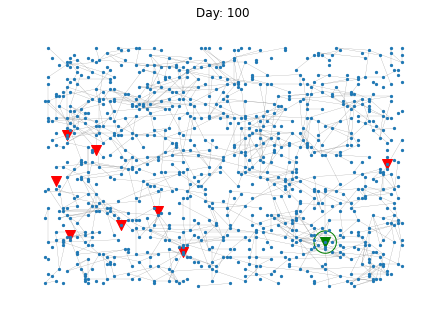

In [45]:
simulate_cops_n_robbers(config, city, 100)

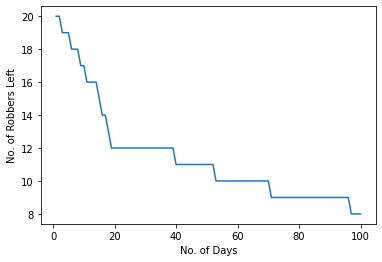

In [46]:
plt.plot(list(count_of_robber_daywise.keys()),list(count_of_robber_daywise.values()))
plt.xlabel("No. of Days")
plt.ylabel("No. of Robbers Left")
plt.show()

In [13]:
count_of_robber_daywise={}
config=get_multi_cop_robber_configurations(20,100,1)
city = create_city(config)

City Created!
Civilians Added!
Relationships Established.


In [ ]:
simulate_cops_n_robbers(config, city, 100)

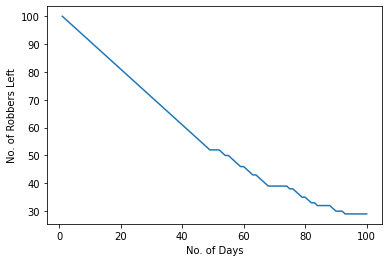

In [15]:
plt.plot(list(count_of_robber_daywise.keys()),list(count_of_robber_daywise.values()))
plt.xlabel("No. of Days")
plt.ylabel("No. of Robbers Left")
plt.show()

# Analysis of cases on Metropolitan city

In [ ]:
count_of_robber_daywise={}
config = get_multi_robber_configurations(20,2)
city = create_city(config)

City Created!
Civilians Added!
Relationships Established.


potential_targets: {8: 13381, 9: 93656, 23: 36846, 35: 3984691, 36: 137774, 40: 1872913, 48: 794449, 58: 7340, 76: 153766, 77: 122727, 90: 1075275, 95: 424642, 97: 1217810, 109: 846701, 116: 1024, 137: 34266860, 140: 4548939, 154: 31756, 155: 236423, 162: 5938, 165: 4058546, 166: 83909, 167: 223973, 170: 694535, 173: 2445828, 175: 5786181, 203: 18999, 215: 0, 220: 137829, 226: 38322, 227: 639457, 231: 606529, 235: 53968, 237: 982610, 246: 113852, 254: 2985, 268: 13341719, 272: 26509, 287: 1020471, 296: 3973, 298: 40086, 303: 7550910, 307: 81931, 312: 83465, 319: 1212238, 321: 5685474, 331: 240334, 332: 6163, 335: 64280, 366: 1586667, 377: 2005727, 379: 2583428, 380: 65455, 403: 383006, 418: 6226021, 421: 139729, 424: 76738, 427: 1366158, 435: 186212, 448: 290807, 451: 36195, 455: 5522928, 463: 3279457, 464: 1025811, 474: 97203, 499: 5236, 512: 1, 537: 26319, 546: 140782, 553: 48671, 566: 101014, 574: 249605, 576: 11253, 580: 12167083, 586: 689415, 588: 237863, 591: 475536, 597: 8425071

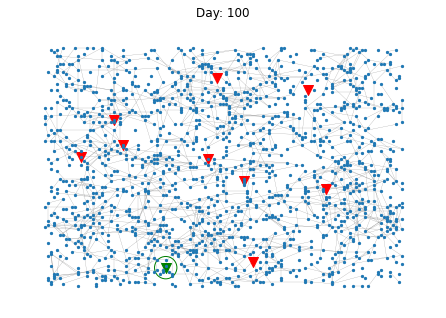

100

In [ ]:
simulate_cops_n_robbers(config, city, 100)

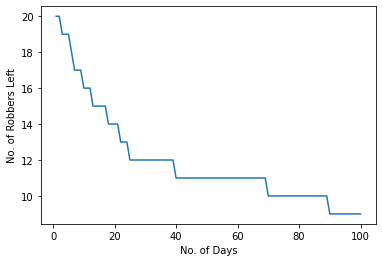

In [ ]:
plt.plot(list(count_of_robber_daywise.keys()),list(count_of_robber_daywise.values()))
plt.xlabel("No. of Days")
plt.ylabel("No. of Robbers Left")
plt.show()

In [ ]:
count_of_robber_daywise={}
config=get_multi_cop_robber_configurations(20,100,2)
city = create_city(config)

City Created!
Civilians Added!
Relationships Established.


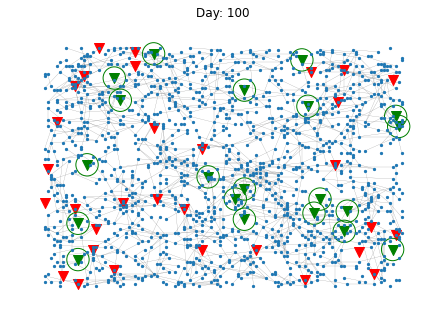

100

In [ ]:
simulate_cops_n_robbers(config, city, 100)

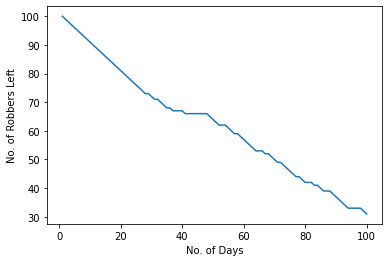

In [ ]:
plt.plot(list(count_of_robber_daywise.keys()),list(count_of_robber_daywise.values()))
plt.xlabel("No. of Days")
plt.ylabel("No. of Robbers Left")
plt.show()

# Analysis of cases on Village

In [ ]:
count_of_robber_daywise={}
config = get_multi_robber_configurations(20,3)
city = create_city(config)

City Created!
Civilians Added!
Relationships Established.


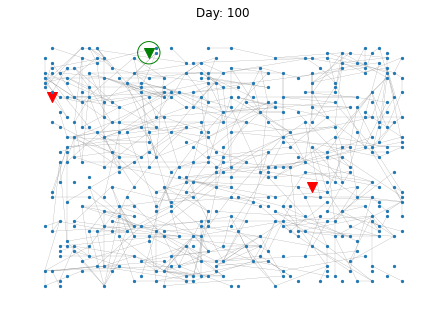

100

In [ ]:
simulate_cops_n_robbers(config, city, 100)

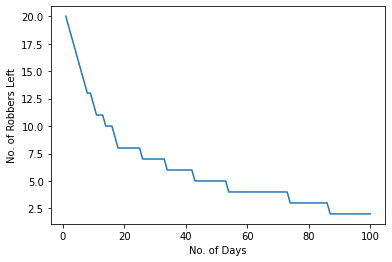

In [ ]:
plt.plot(list(count_of_robber_daywise.keys()),list(count_of_robber_daywise.values()))
plt.xlabel("No. of Days")
plt.ylabel("No. of Robbers Left")
plt.show()

In [ ]:
count_of_robber_daywise={}
config=get_multi_cop_robber_configurations(20,100,3)
city = create_city(config)

City Created!
Civilians Added!
Relationships Established.


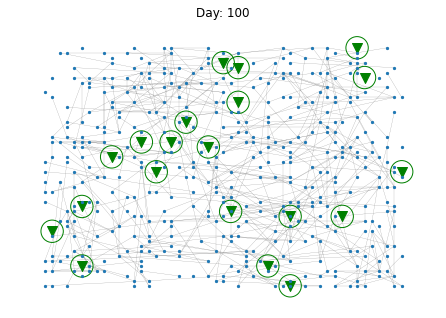

100

In [ ]:
simulate_cops_n_robbers(config, city, 100)

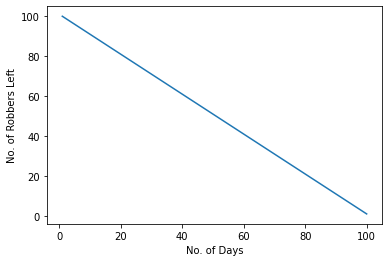

In [ ]:
plt.plot(list(count_of_robber_daywise.keys()),list(count_of_robber_daywise.values()))
plt.xlabel("No. of Days")
plt.ylabel("No. of Robbers Left")
plt.show()

 # Varyting Alertness

# Varying Community Strength

In [ ]:
count_of_robber_daywise={}
config = get_multi_robber_configurations(20,1)
config=get_community_strength_configurations(config,2)
city = create_city(config)

City Created!
Civilians Added!
Relationships Established.


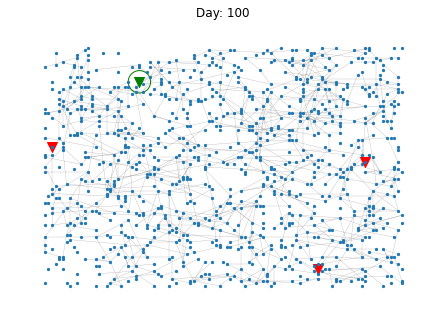

100

In [ ]:
simulate_cops_n_robbers(config, city, 100)

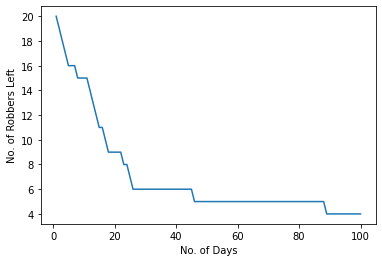

In [ ]:
plt.plot(list(count_of_robber_daywise.keys()),list(count_of_robber_daywise.values()))
plt.xlabel("No. of Days")
plt.ylabel("No. of Robbers Left")
plt.show()

In [ ]:
count_of_robber_daywise={}
config = get_multi_robber_configurations(20,1)
config=get_community_strength_configurations(config,4)
city = create_city(config)

City Created!
Civilians Added!
Relationships Established.


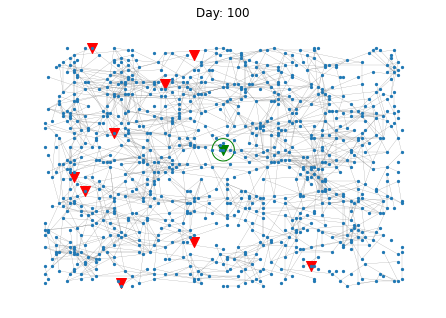

100

In [ ]:
simulate_cops_n_robbers(config, city, 100)

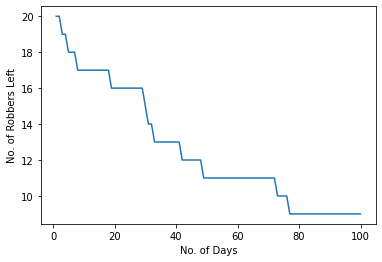

In [ ]:
plt.plot(list(count_of_robber_daywise.keys()),list(count_of_robber_daywise.values()))
plt.xlabel("No. of Days")
plt.ylabel("No. of Robbers Left")
plt.show()

In [ ]:
count_of_robber_daywise={}
config = get_multi_robber_configurations(20,1)
config=get_community_strength_configurations(config,8)
city = create_city(config)

City Created!
Civilians Added!
Relationships Established.


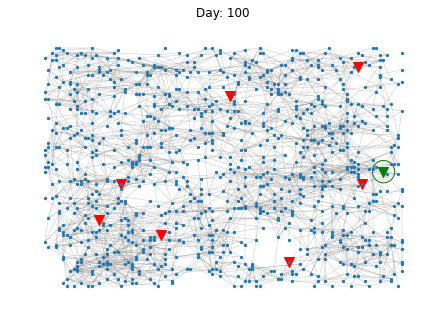

100

In [ ]:
simulate_cops_n_robbers(config, city, 100)

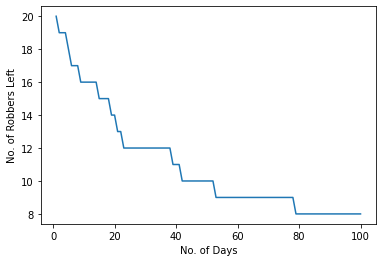

In [ ]:
plt.plot(list(count_of_robber_daywise.keys()),list(count_of_robber_daywise.values()))
plt.xlabel("No. of Days")
plt.ylabel("No. of Robbers Left")
plt.show()

In [47]:
count_of_robber_daywise={}
config = get_multi_robber_configurations(20,1)
config=get_community_strength_configurations(config,16)
city = create_city(config)

City Created!
Civilians Added!
Relationships Established.


{3: 70726, 14: 229388, 30: 18178, 87: 687086, 89: 1, 99: 478621, 113: 1386362, 115: 474603, 120: 202214, 128: 2478, 136: 248815, 148: 470855, 156: 37387, 158: 3143, 182: 1430122, 194: 50998, 223: 6893837, 229: 6509799, 230: 441427, 231: 170910, 241: 101351, 249: 784224, 252: 616083, 253: 951975, 264: 173914, 278: 8952, 289: 239728, 293: 179428, 299: 11201, 307: 7022, 324: 659206, 348: 8642, 355: 42985, 356: 1092091, 358: 1992305, 368: 1976266, 370: 902375, 380: 207150, 381: 571986, 388: 1023301, 407: 34109, 426: 49890, 449: 388358, 450: 370737, 467: 1200418, 509: 3241503, 536: 1839579, 541: 34280, 546: 953548, 554: 96231, 562: 279313, 585: 83135, 609: 49959, 610: 23897, 612: 484751, 624: 1889592, 661: 6409, 681: 14073251, 709: 26406, 717: 25909, 746: 1574719, 751: 8792555, 758: 612920, 784: 1056343, 799: 374002, 808: 782818, 823: 172290, 830: 3986865, 838: 1934142, 857: 890674, 866: 0, 874: 581048, 888: 112649, 894: 1049623, 903: 371890, 908: 101448, 909: 373115, 943: 1147311, 944: 521

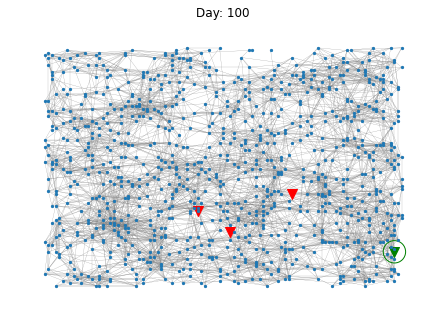

In [48]:
simulate_cops_n_robbers(config, city, 50)

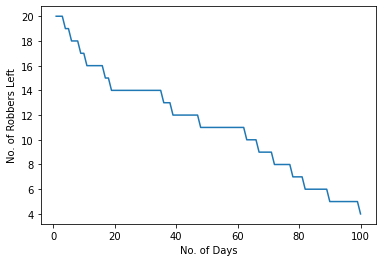

In [50]:
plt.plot(list(count_of_robber_daywise.keys()),list(count_of_robber_daywise.values()))
plt.xlabel("No. of Days")
plt.ylabel("No. of Robbers Left")
plt.show()

# Observation: We can observer as we increse the community strength The probability of robber getting caught increases and more no. of robbers starts to get caught.

# Murder Threshhold

In [61]:
count_of_robber_daywise={}
config = get_multi_robber_configurations(20,1)
config=get_crime_intensity_configurations(config,0.5)
city = create_city(config)

City Created!
Civilians Added!
Relationships Established.


{7: 6269483, 21: 1105544, 23: 41318, 35: 174262, 43: 397471, 50: 88460, 56: 278803, 63: 741621, 80: 426376, 84: 7283, 97: 160006, 100: 56465, 121: 386999, 181: 45183, 190: 2487511, 246: 510321, 248: 22361576, 263: 34730, 264: 1644274, 280: 2395867, 305: 16302, 310: 421414, 312: 463938, 315: 214970, 317: 151996, 328: 2379516, 331: 1568392, 333: 332594, 340: 23769, 344: 719086, 347: 17827264, 377: 193750, 392: 3416430, 401: 160421, 431: 62846, 449: 49599, 469: 39687, 471: 152345, 472: 575634, 480: 55325, 489: 2157142, 498: 234306, 499: 1152617, 500: 38443, 503: 131235, 504: 1740943, 524: 49329, 550: 1269784, 552: 1298981, 557: 22098, 606: 88016, 613: 3289068, 615: 145503, 621: 7679064, 653: 6540277, 666: 624987, 677: 523651, 680: 338536, 685: 319152, 688: 303713, 703: 3379890, 709: 1, 717: 579938, 723: 285535, 725: 294080, 728: 70872, 734: 10230, 748: 66126, 749: 143243, 770: 200962, 774: 41297, 776: 182288, 780: 25178019, 786: 343549, 810: 50749, 815: 2874361, 818: 285802, 829: 5495040,

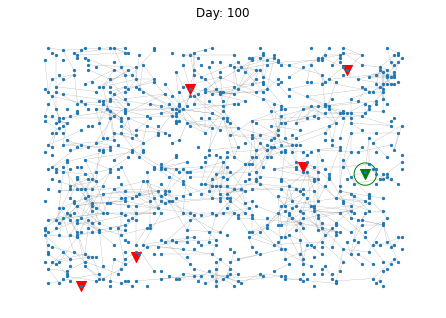

In [62]:
simulate_cops_n_robbers(config, city, 100)

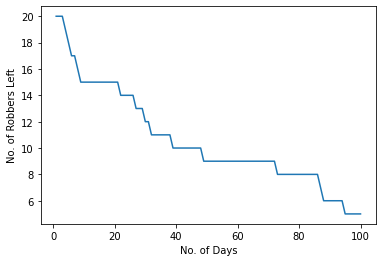

In [63]:
plt.plot(list(count_of_robber_daywise.keys()),list(count_of_robber_daywise.values()))
plt.xlabel("No. of Days")
plt.ylabel("No. of Robbers Left")
plt.show()

In [54]:
count_of_robber_daywise={}
config = get_multi_robber_configurations(20,1)
config=get_crime_intensity_configurations(config,0.3)
city = create_city(config)

City Created!
Civilians Added!
Relationships Established.


{0: 46999, 6: 35255, 13: 7323, 16: 273005, 30: 25008, 35: 886852, 46: 37549, 48: 1692940, 51: 2329661, 55: 407256, 56: 610180, 70: 3698629, 80: 35769, 89: 3102792, 98: 10164, 108: 224451, 128: 5767815, 130: 464409, 142: 125081, 144: 172796, 145: 78716, 147: 22318217, 148: 1688067, 156: 290328, 163: 37454, 173: 98086, 181: 3297889, 199: 111565, 221: 1939034, 224: 16290, 235: 8665890, 236: 2157050, 237: 1230801, 239: 12597, 240: 567910, 242: 3635329, 259: 520458, 262: 4937, 292: 552773, 312: 31188, 332: 51947, 334: 553608, 343: 5072383, 357: 884768, 360: 22552, 361: 13405, 362: 5538713, 365: 2402911, 370: 264270, 374: 14136, 375: 123032, 381: 139908, 391: 884517, 402: 3257199, 433: 6037158, 437: 477307, 499: 99963, 501: 31071, 511: 7116213, 514: 3509076, 522: 15413700, 527: 490961, 531: 18442, 538: 955843, 547: 1437248, 548: 66881, 549: 47403, 559: 153765, 560: 678964, 562: 2020407, 565: 4501430, 570: 288432, 602: 253841, 608: 48834, 630: 451296, 657: 3276767, 670: 0, 672: 220401, 680: 3

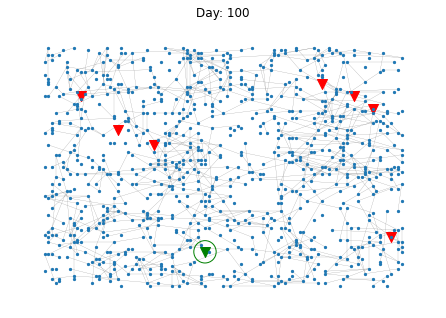

In [55]:
simulate_cops_n_robbers(config, city, 100)

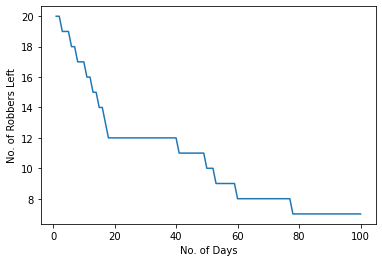

In [56]:
plt.plot(list(count_of_robber_daywise.keys()),list(count_of_robber_daywise.values()))
plt.xlabel("No. of Days")
plt.ylabel("No. of Robbers Left")
plt.show()

In [57]:
count_of_robber_daywise={}
config = get_multi_robber_configurations(20,1)
config=get_crime_intensity_configurations(config,0.1)
city = create_city(config)

City Created!
Civilians Added!
Relationships Established.


{14: 1526959, 18: 167899, 19: 1395037, 22: 2792960, 37: 620078, 40: 813094, 45: 249926, 48: 19275, 53: 159933986, 54: 157917, 55: 3074749, 56: 1862, 58: 0, 62: 33432, 68: 2339291, 71: 3002707, 73: 75328, 77: 167040, 83: 250820, 85: 1608755, 87: 36602, 90: 56712, 93: 156558, 94: 173171, 95: 95353, 96: 145057, 105: 817314, 111: 252109, 112: 85057, 123: 16784, 128: 6879952, 139: 18679, 140: 419888, 151: 980747, 162: 454655, 164: 9380676, 173: 263918, 174: 527483, 175: 205705, 179: 127660, 181: 445046, 187: 73814, 188: 57706, 191: 81648, 210: 67903, 211: 22160, 221: 394257, 227: 11144, 228: 46436, 234: 5030399, 242: 0, 244: 1880, 253: 1075595, 255: 4861875, 260: 8585673, 265: 701877, 267: 572327, 272: 234299, 278: 10795971, 279: 210909, 283: 2560954, 313: 1337398, 316: 60401, 320: 98324, 340: 646957, 341: 187946, 342: 220875, 352: 13858, 360: 1013568, 365: 178989, 369: 92221, 373: 53939, 375: 23866, 378: 3991, 381: 44500, 387: 181867, 388: 7697, 392: 427019, 393: 48806, 394: 1789920, 395: 

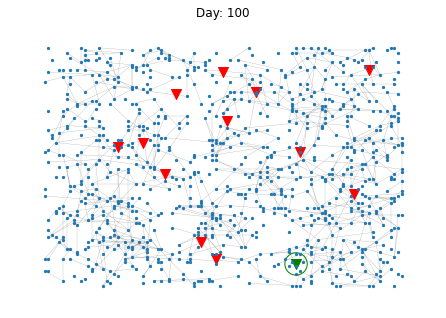

In [58]:
simulate_cops_n_robbers(config, city, 100)

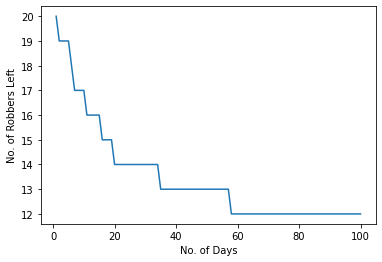

In [59]:
plt.plot(list(count_of_robber_daywise.keys()),list(count_of_robber_daywise.values()))
plt.xlabel("No. of Days")
plt.ylabel("No. of Robbers Left")
plt.show()

# Observation On decreasing the crime threshhold it gets tougher to catch robbers

# Case of multiple cops

In [93]:
count_of_robber_daywise={}
config = get_multi_cop_configurations(20,1,20)
config=get_crime_intensity_configurations(config,0.8)
city = create_city(config)
x=[0.8,0.1]
y=[]


City Created!
Civilians Added!
Relationships Established.


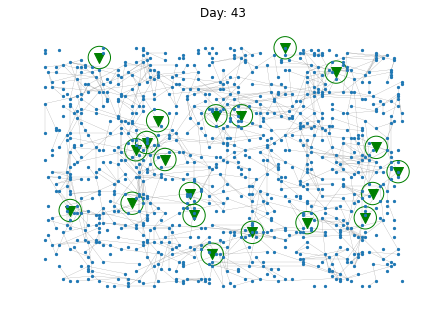

Robber Caught!


In [94]:
simulate_cops_n_robbers(config, city, 100)

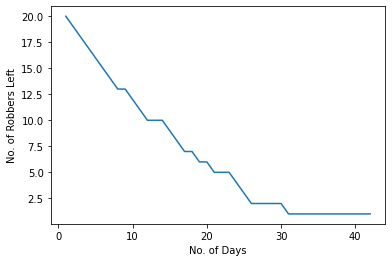

In [95]:
plt.plot(list(count_of_robber_daywise.keys()),list(count_of_robber_daywise.values()))
y.append(len(list(count_of_robber_daywise.keys())))
plt.xlabel("No. of Days")
plt.ylabel("No. of Robbers Left")
plt.show()

In [96]:
count_of_robber_daywise={}
config = get_multi_cop_configurations(20,1,20)
config=get_crime_intensity_configurations(config,0.1)
city = create_city(config)

City Created!
Civilians Added!
Relationships Established.


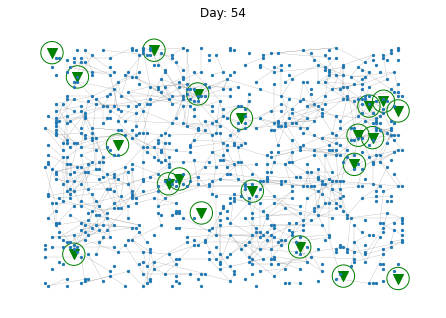

Robber Caught!


In [97]:
simulate_cops_n_robbers(config, city, 100)

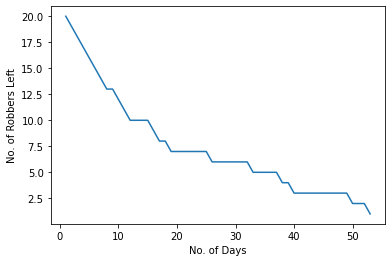

In [98]:
plt.plot(list(count_of_robber_daywise.keys()),list(count_of_robber_daywise.values()))
y.append(len(list(count_of_robber_daywise.keys())))
plt.xlabel("No. of Days")
plt.ylabel("No. of Robbers Left")
plt.show()

Multiple COPS


Text(0, 0.5, 'No. of Days it took to catch all Robbers')

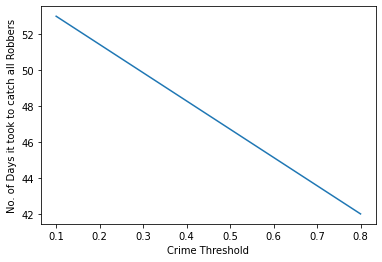

In [104]:
plt.plot(x,y)
print("Multiple COPS")
plt.xlabel('Crime Threshold')
plt.ylabel("No. of Days it took to catch all Robbers")


# Observation Even in case of multiple cops when we decrease the crime intensity threshhold it gets tougher to catch robbers.

In [132]:
count_of_robber_daywise={}
x=[0,1,2]
y=[]
config=get_multi_cop_robber_configurations(2,30,1)
config=get_cascading_alertness_configurations(config,1)
city = create_city(config)

City Created!
Civilians Added!
Relationships Established.


{4: 848, 6: 47569, 8: 850, 13: 794, 16: 3164, 28: 5080, 42: 11064, 44: 6582, 47: 154549, 51: 4237, 54: 24626, 60: 43, 61: 5771, 65: 492, 68: 10976, 71: 23, 90: 30834, 93: 1447, 94: 21491, 101: 32562, 104: 34580, 105: 580, 108: 2708, 122: 2725, 132: 7995, 134: 4737, 135: 10393, 143: 7121, 146: 7290, 147: 2376, 148: 111, 150: 4642, 158: 3802, 167: 356, 171: 2031, 177: 672, 179: 9169, 185: 6366, 191: 0, 194: 62581, 202: 70033, 205: 5474, 208: 2779, 211: 3576, 212: 10844, 214: 1603, 219: 3329, 228: 4651, 233: 6942, 237: 3990, 239: 20185, 242: 2424, 244: 785, 250: 4333, 253: 27258, 259: 12146, 266: 5701, 275: 12669, 278: 4271, 283: 2674, 290: 38261, 292: 933, 295: 950, 302: 10249, 304: 3656, 307: 7339, 310: 1401, 312: 1, 321: 628, 323: 136, 334: 13103, 337: 17545, 341: 1810, 343: 5778, 345: 3353, 347: 2073, 351: 3072, 355: 24242, 356: 1, 359: 1306, 362: 644, 368: 3459, 372: 6259, 373: 29582, 375: 620, 376: 7998, 378: 614, 380: 28622, 382: 74, 383: 377, 384: 5165, 388: 4419, 395: 32569, 406:

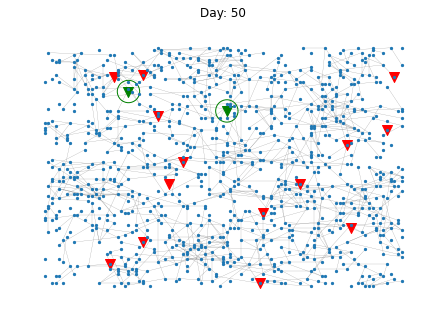

In [133]:
simulate_cops_n_robbers(config, city, 50)
tp=list(count_of_robber_daywise.values())
y.append(tp[-1])

In [134]:
count_of_robber_daywise={}
config=get_multi_cop_robber_configurations(2,30,1)
config=get_cascading_alertness_configurations(config,2)
city = create_city(config)

City Created!
Civilians Added!
Relationships Established.


{0: 264, 6: 3575, 8: 1263, 13: 194, 21: 11380, 22: 5995, 23: 12498, 26: 1441, 27: 10466, 32: 42, 33: 6070, 35: 13742, 41: 840, 42: 83, 54: 3927, 55: 13421, 58: 751, 77: 3682, 83: 716, 84: 10169, 85: 155, 87: 2741, 88: 2670, 91: 6550, 92: 4666, 97: 552, 100: 5445, 101: 4031, 102: 685, 111: 124239, 117: 199, 120: 907, 139: 7986, 143: 1079, 145: 39111, 148: 3449, 168: 50, 175: 2594, 176: 13242, 177: 1133, 178: 350, 180: 884, 184: 1079, 189: 4226, 212: 78425, 215: 207, 216: 2827, 217: 171, 219: 155844, 220: 19712, 226: 2733, 228: 2225, 230: 11707, 232: 1944, 236: 5806, 242: 1304, 244: 33469, 254: 1117, 257: 930, 260: 460, 263: 2044, 264: 1523, 265: 564, 269: 10588, 270: 17491, 279: 4484, 280: 3244, 282: 3936, 283: 5161, 284: 4231, 294: 31352, 302: 588, 314: 40337, 315: 2320, 316: 26388, 317: 154, 319: 337, 321: 882, 329: 4584, 340: 4487, 354: 3604, 356: 3233, 358: 8936, 367: 7605, 369: 240, 370: 1536, 371: 12275, 372: 359, 373: 3106, 376: 3729, 384: 5211, 388: 461, 395: 14972, 398: 5182, 3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: RankWarning: Polyfit may be poorly conditioned


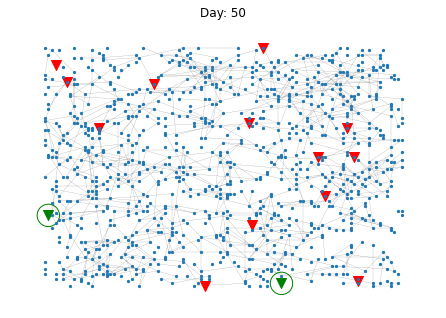

In [135]:
simulate_cops_n_robbers(config, city, 50)
tp=list(count_of_robber_daywise.values())
y.append(tp[-1])

In [136]:
count_of_robber_daywise={}
config=get_multi_cop_robber_configurations(2,30,1)
config=get_cascading_alertness_configurations(config,3)
city = create_city(config)

City Created!
Civilians Added!
Relationships Established.


{0: 17184, 2: 269, 3: 3286, 4: 2270, 8: 0, 16: 160, 17: 37188, 19: 2009, 20: 8885, 27: 1422, 31: 421, 32: 3904, 38: 9420, 42: 11053, 44: 736, 48: 2205, 50: 11328, 51: 8700, 58: 135, 62: 2624, 63: 228, 65: 587, 68: 2085, 69: 7706, 74: 26713, 76: 2932, 77: 6311, 80: 1284, 81: 2826, 90: 736, 93: 33679, 95: 40740, 96: 28670, 98: 10734, 100: 1290, 103: 2047, 108: 1276, 109: 24077, 113: 14502, 117: 17274, 123: 6342, 127: 813, 131: 10760, 136: 3715, 139: 542, 145: 58, 152: 4147, 156: 6438, 165: 12981, 174: 26877, 175: 6667, 176: 3343, 177: 9878, 180: 10246, 193: 3215, 196: 13352, 197: 20999, 204: 4746, 205: 1199, 207: 911, 212: 23157, 214: 34733, 215: 147, 218: 19, 219: 225, 223: 13649, 224: 20378, 226: 13910, 231: 6211, 241: 899, 245: 2286, 247: 3585, 249: 8317, 253: 667, 254: 1890, 255: 3336, 257: 4546, 259: 2451, 260: 444, 263: 14872, 264: 14444, 269: 15726, 278: 20370, 284: 1696, 286: 7395, 287: 10764, 290: 2530, 291: 3341, 294: 906, 298: 21744, 303: 3538, 319: 505, 326: 2748, 330: 520, 3

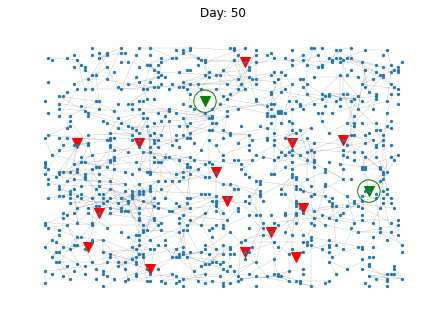

In [137]:
simulate_cops_n_robbers(config, city, 50)
tp=list(count_of_robber_daywise.values())
y.append(tp[-1])

Text(0, 0.5, 'No. of Robbers left after 100 days ')

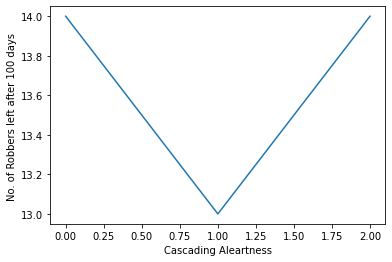

In [138]:
plt.plot(x,y)
plt.xlabel('Cascading Aleartness')
plt.ylabel("No. of Robbers left after 100 days ")
